In [21]:
import pandas as pd
import numpy as np
import sklearn as sk
import openpyxl
import statsmodels.graphics.api as smg
import matplotlib.pyplot as plt 
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestRegressor
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [22]:
datos = pd.read_excel('/home/erick_castro/Documentos/Inteligencia/Datos.xlsx', sheet_name = "Hoja1")
datos = pd.DataFrame(datos)

In [23]:
datos.head()

,Evento,A1,D1,Ai1,MI1,CI1,A2,D2,Ai2,MI2,...,SM40,SM60,SM80,SM100,24PA1,24PA2,48PA1,48PA2,MAXD,INITIALQ
0,Evento 1,16.382445,55,17.871758,399.148547,27.132184,12.66,55,13.810909,93.850,...,0.490273,0.519179,0.535343,0.503777,16.382445,13.0,19.460113,13.4,17.246332,6.854821
1,Evento 2,15.827108,35,27.132184,312.330000,27.132184,14.80,40,22.200000,84.375,...,0.495030,0.524897,0.540182,0.506062,56.089048,50.2,56.089048,50.2,20.280403,7.080917
2,Evento 3,54.700705,1125,2.917371,138.830000,11.285883,47.00,1125,2.506667,109.375,...,0.505497,0.537286,0.552282,0.514057,56.089048,50.2,56.089048,50.2,30.667560,7.092906
3,Evento 4,13.883428,105,7.933387,86.771423,7.933387,12.40,95,7.831579,28.125,...,0.515011,0.553487,0.572852,0.534618,1.000000,1.0,1.000000,1.0,15.663358,9.328517
4,Evento 5,5.553371,60,5.553371,104.125708,8.554286,5.00,50,6.000000,21.875,...,0.545459,0.576360,0.598261,0.557462,23.324159,18.2,60.809413,50.8,16.910000,13.085455


In [24]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Evento    243 non-null    object 
 1   A1        243 non-null    float64
 2   D1        243 non-null    int64  
 3   Ai1       243 non-null    float64
 4   MI1       243 non-null    float64
 5   CI1       243 non-null    float64
 6   A2        243 non-null    float64
 7   D2        243 non-null    int64  
 8   Ai2       243 non-null    float64
 9   MI2       243 non-null    float64
 10  CI2       243 non-null    float64
 11  SM5       243 non-null    float64
 12  SM40      243 non-null    float64
 13  SM60      243 non-null    float64
 14  SM80      243 non-null    float64
 15  SM100     243 non-null    float64
 16  24PA1     219 non-null    float64
 17  24PA2     219 non-null    float64
 18  48PA1     219 non-null    float64
 19  48PA2     219 non-null    float64
 20  MAXD      243 non-null    float6

In [25]:
datos.shape

(243, 22)

In [26]:
datos = datos.dropna(axis = 0, how ="any")

In [27]:
datos.shape

(218, 22)

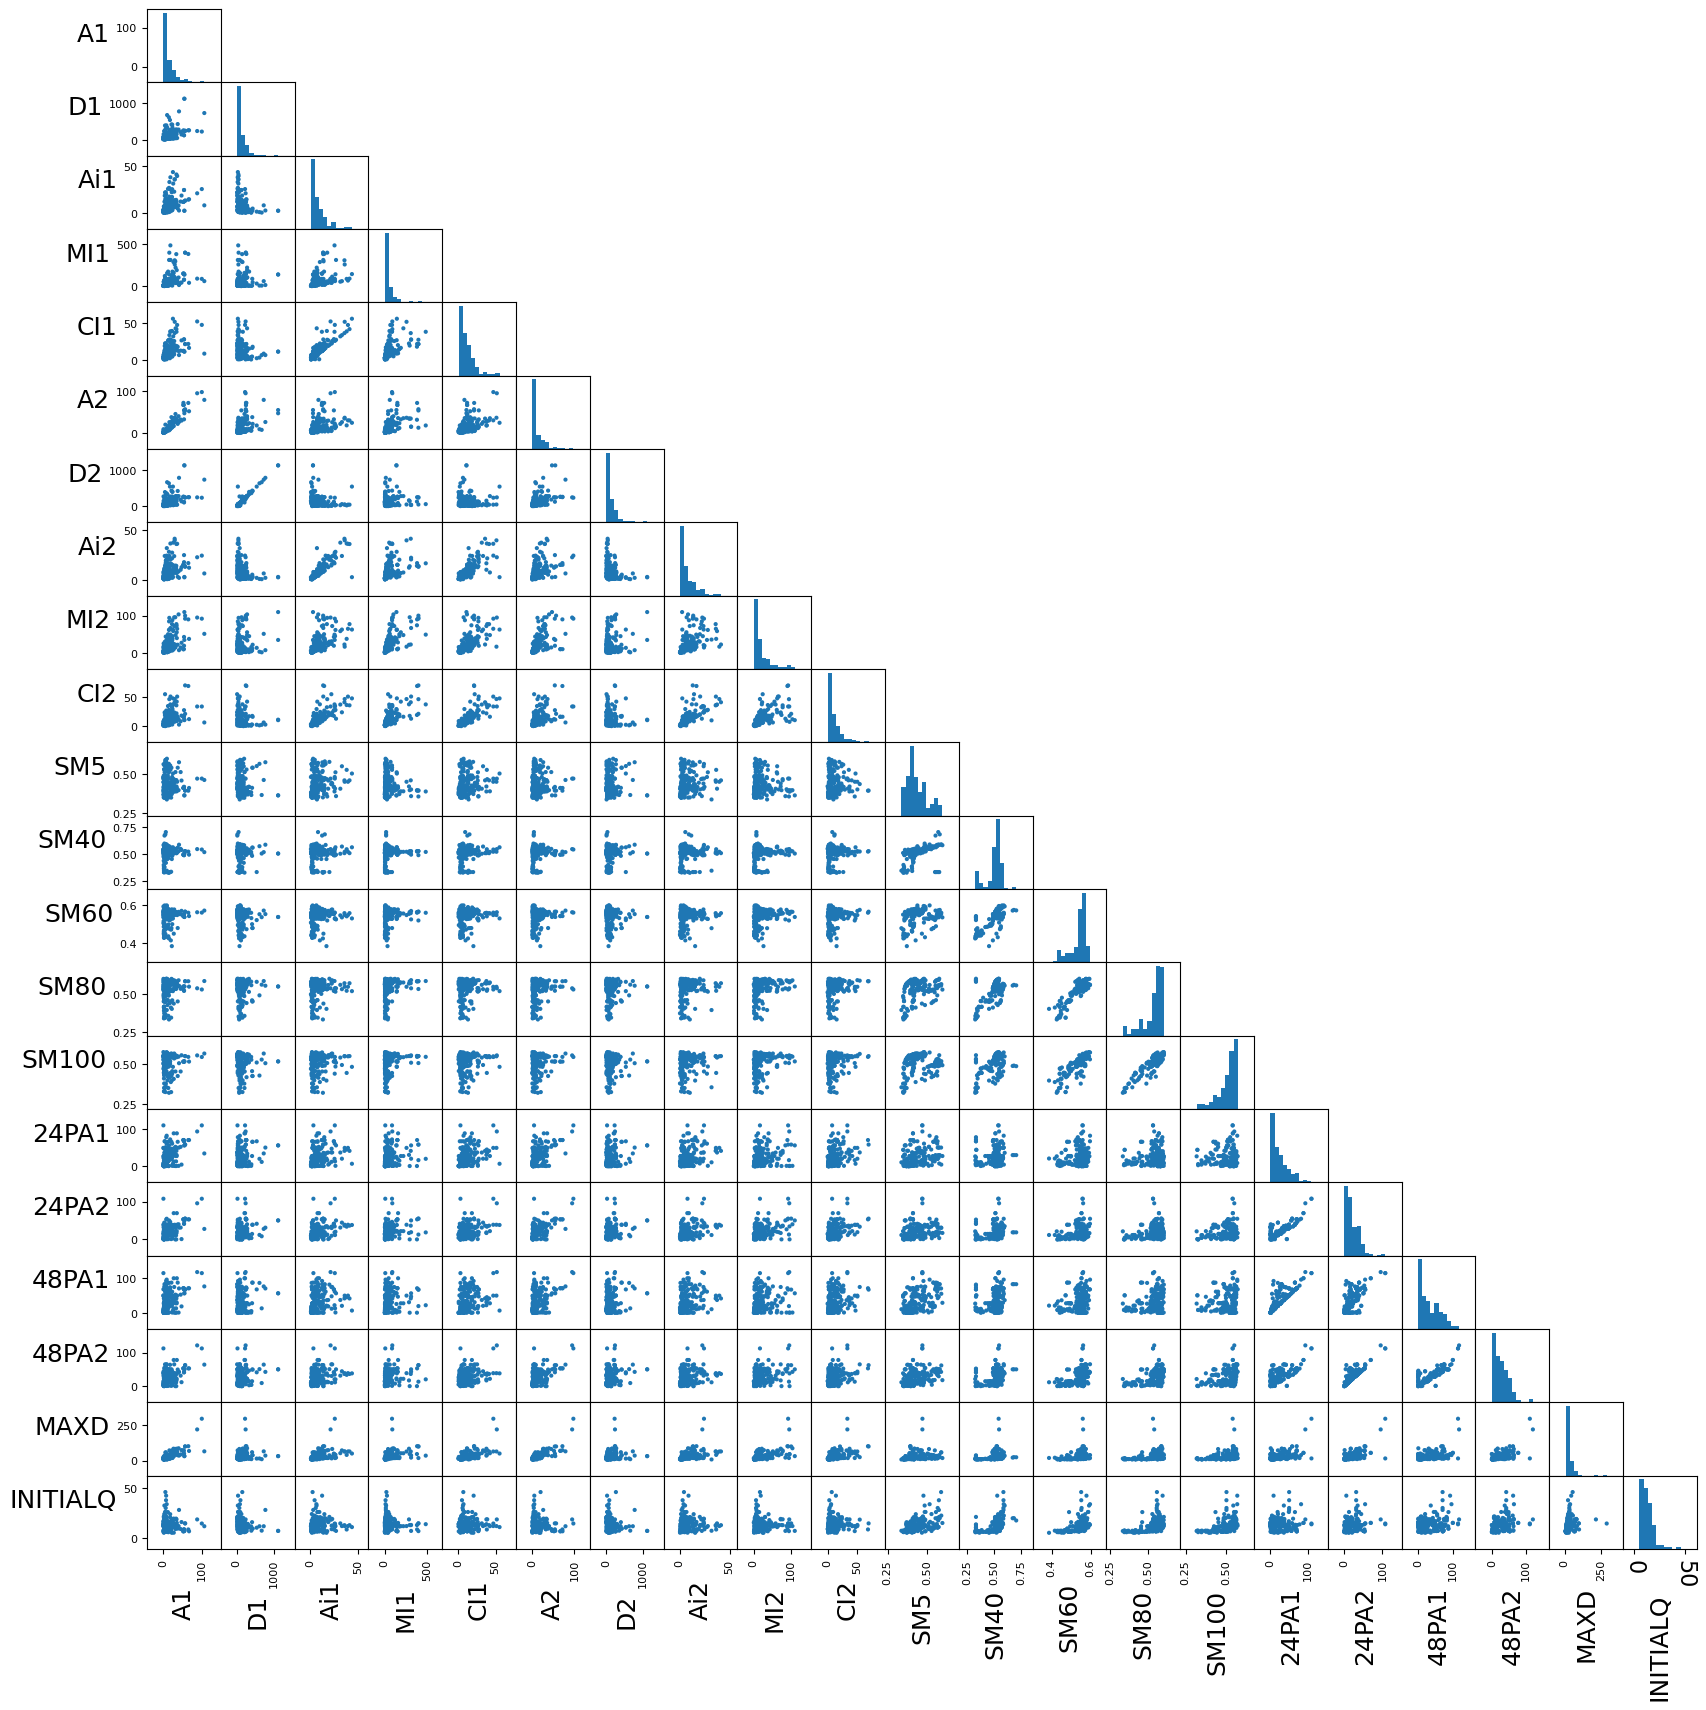

In [28]:
axes = pd.plotting.scatter_matrix(datos, alpha=1, figsize=(20,20), range_padding=0.8 )
plt.xticks(fontsize = 16, rotation = -90)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
for i in range(np.shape(axes)[0]):
    for j in range(np.shape(axes)[1]):
        if i < j:
            axes[i,j].set_visible(False)
plt.savefig("scatter_matrix4.jpg", dpi = 500)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


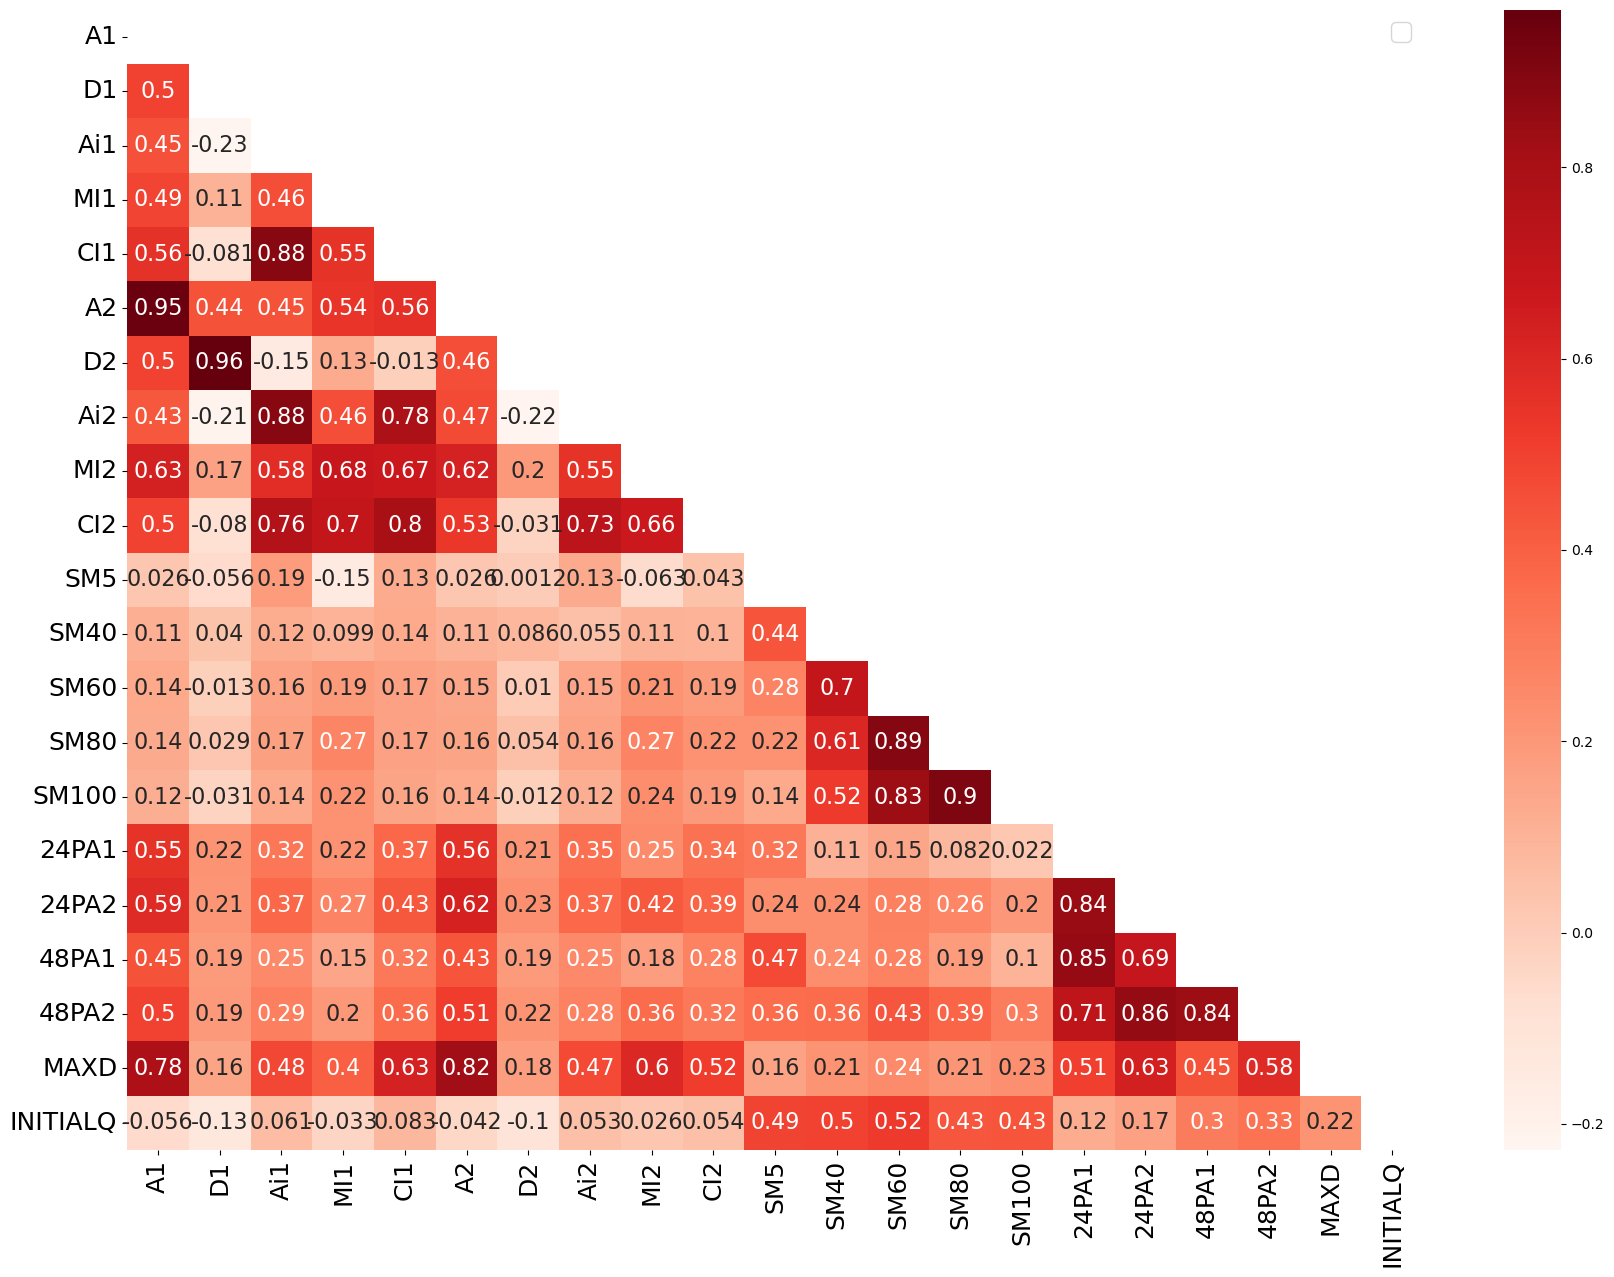

In [39]:
plt.figure(figsize=(18,12))
cor = datos.corr()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,mask=mask, annot_kws={'size': 16})
sns.diverging_palette(20, 12, sep=1, as_cmap=True)
plt.margins(x=0, y=0)
plt.legend(fontsize =18)
plt.yticks(fontsize = 18, rotation=0)
plt.xticks(fontsize = 18, rotation =90)
plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=1.05, wspace=2, hspace=2)
plt.savefig("Correlation_map.jpg", dpi = 500)

In [30]:
x_expl=datos.drop(['MAXD', 'Evento'],axis=1)
Qmax=datos[['MAXD']]

In [31]:
x_expl.head()

,A1,D1,Ai1,MI1,CI1,A2,D2,Ai2,MI2,CI2,SM5,SM40,SM60,SM80,SM100,24PA1,24PA2,48PA1,48PA2,INITIALQ
0,16.382445,55,17.871758,399.148547,27.132184,12.66,55,13.810909,93.850,46.640000,0.355535,0.490273,0.519179,0.535343,0.503777,16.382445,13.0,19.460113,13.4,6.854821
1,15.827108,35,27.132184,312.330000,27.132184,14.80,40,22.200000,84.375,12.960000,0.357889,0.495030,0.524897,0.540182,0.506062,56.089048,50.2,56.089048,50.2,7.080917
2,54.700705,1125,2.917371,138.830000,11.285883,47.00,1125,2.506667,109.375,10.451613,0.362596,0.505497,0.537286,0.552282,0.514057,56.089048,50.2,56.089048,50.2,7.092906
3,13.883428,105,7.933387,86.771423,7.933387,12.40,95,7.831579,28.125,11.328000,0.379070,0.515011,0.553487,0.572852,0.534618,1.000000,1.0,1.000000,1.0,9.328517
4,5.553371,60,5.553371,104.125708,8.554286,5.00,50,6.000000,21.875,12.500000,0.416726,0.545459,0.576360,0.598261,0.557462,23.324159,18.2,60.809413,50.8,13.085455


In [32]:
Qmax.head()


,MAXD
0,17.246332
1,20.280403
2,30.667560
3,15.663358
4,16.910000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


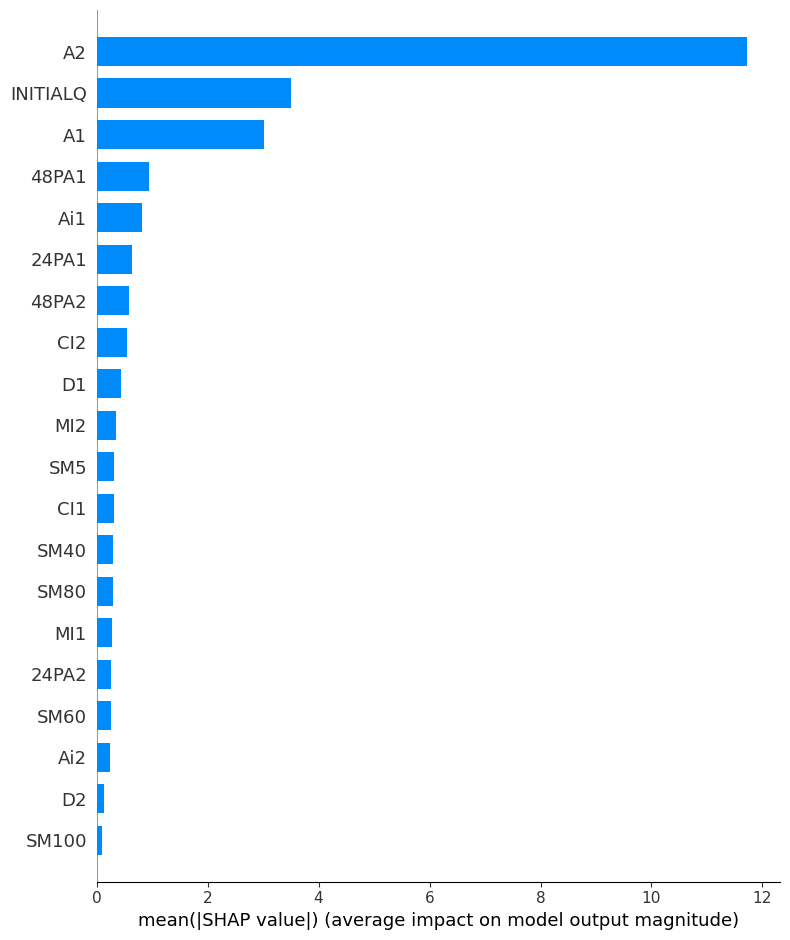

In [33]:
model = RandomForestRegressor(max_depth=10, n_estimators=12)
model.fit(x_expl, Qmax)
shap_values = shap.TreeExplainer(model).shap_values(x_expl)
shap.summary_plot(shap_values, x_expl, plot_type="bar")

In [34]:
selector = VarianceThreshold(threshold=0.25)
selector.fit(x_expl)
print(selector.get_support())
x_expl.columns[selector.get_support()]

[ True  True  True  True  True  True  True  True  True  True False False
 False False False  True  True  True  True  True]


Index(['A1', 'D1', 'Ai1', 'MI1', 'CI1', 'A2', 'D2', 'Ai2', 'MI2', 'CI2',
       '24PA1', '24PA2', '48PA1', '48PA2', 'INITIALQ'],
      dtype='object')

In [35]:
C_esta_log = df_log10 = np.log(datos['A2'])



In [36]:
datos.head()

,Evento,A1,D1,Ai1,MI1,CI1,A2,D2,Ai2,MI2,...,SM40,SM60,SM80,SM100,24PA1,24PA2,48PA1,48PA2,MAXD,INITIALQ
0,Evento 1,16.382445,55,17.871758,399.148547,27.132184,12.66,55,13.810909,93.850,...,0.490273,0.519179,0.535343,0.503777,16.382445,13.0,19.460113,13.4,17.246332,6.854821
1,Evento 2,15.827108,35,27.132184,312.330000,27.132184,14.80,40,22.200000,84.375,...,0.495030,0.524897,0.540182,0.506062,56.089048,50.2,56.089048,50.2,20.280403,7.080917
2,Evento 3,54.700705,1125,2.917371,138.830000,11.285883,47.00,1125,2.506667,109.375,...,0.505497,0.537286,0.552282,0.514057,56.089048,50.2,56.089048,50.2,30.667560,7.092906
3,Evento 4,13.883428,105,7.933387,86.771423,7.933387,12.40,95,7.831579,28.125,...,0.515011,0.553487,0.572852,0.534618,1.000000,1.0,1.000000,1.0,15.663358,9.328517
4,Evento 5,5.553371,60,5.553371,104.125708,8.554286,5.00,50,6.000000,21.875,...,0.545459,0.576360,0.598261,0.557462,23.324159,18.2,60.809413,50.8,16.910000,13.085455


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


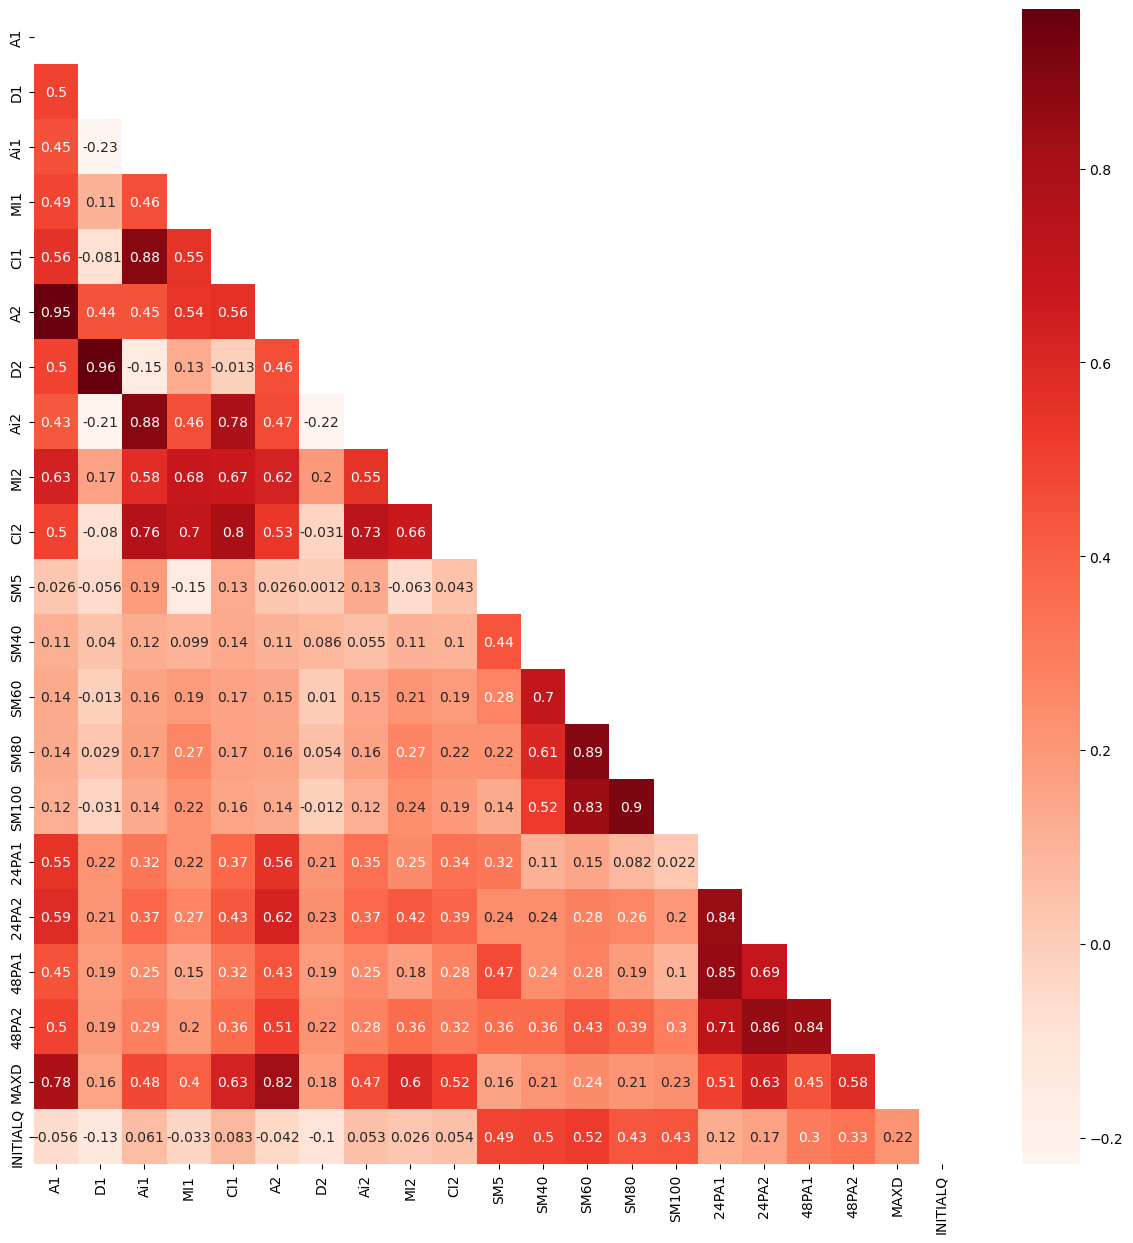

In [37]:
plt.figure(figsize=(15,15))
cor = datos.corr()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,mask=mask )
plt.show()

In [38]:
x_expl2 = x_expl.drop(['Hs_5cm', 'Hs_40_cm', 'Hs_60', 'Hs_80', 'Hs_100'], axis =1)
x_expl2.shape

KeyError: "['Hs_5cm', 'Hs_40_cm', 'Hs_60', 'Hs_80', 'Hs_100'] not found in axis"

In [ ]:
axes = pd.plotting.scatter_matrix(x_expl2, alpha=1, figsize=(20,20), range_padding=0.8 )
plt.xticks(fontsize = 16, rotation = -90)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
for i in range(np.shape(axes)[0]):
    for j in range(np.shape(axes)[1]):
        if i < j:
            axes[i,j].set_visible(False)
plt.savefig("scatter_matrix5.jpg", dpi = 500)

: 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
ld=scaler.fit(x_expl2)
X_scaled=ld.transform(x_expl2)
x_columns= ['A1', 'D1', 'Iensidad_media pl',
       'Intensidad_máxima_pl', 'Intensidad_continuap_pl', 'C_(mm_est',
       'Duración_(min)_esta', 'Intensidad_media_est', 'Intensidad_máxima_est',
       'Intensidad_continua_est', 'Lluvia antecedent_24 horas_pluv',
       'Lluvia antecedent_24_horas_esta', 'Lluvia antecedent_48_horas_pluv',
       'Lluvia_antecedent_48_horas_est', 'Trespuesta_(min)_plub',
       'Trespuesta_est', 'Q_inicial']
X_scaled = pd.DataFrame(X_scaled, columns = x_columns)
X_scaled

: 

In [ ]:
n = 17  # número de features
pca = PCA(n_components= n).fit(X_scaled)
print(pd.DataFrame(pca.components_, index = x_expl2.columns))

: 

In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

: 

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

: 

In [ ]:
pca_samples = pca.transform(X_scaled)

: 

In [ ]:
y= Qmax

: 

In [ ]:
loadings = pca.components_
n_features = pca.n_features_
feature_names = x_expl2.columns

: 

In [ ]:
lo = pd.DataFrame(loadings)
lo.head(7)

: 

In [ ]:
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

: 

In [ ]:
xs = loadings[0]
ys = loadings[1]
plt.figure(figsize = (10,10))
# Plot the loadings on a scatterplot
for i, varnames in enumerate(feature_names):
    plt.scatter(xs[i], ys[i], s=200)
    plt.arrow(
        0, 0, # coordinates of arrow base
        xs[i], # length of the arrow along x
        ys[i], # length of the arrow along y
        color='r', 
        head_width=0.05
        )
    plt.text(xs[i], ys[i], varnames)
 
# Define the axes
xticks = np.linspace(-0.6, 0.6, num=5)
yticks = np.linspace(-0.6, 0.6, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
 
# Show plot
plt.title('')
plt.show()
plt.ylim(-0.6,0.6)

: 

In [ ]:
#### combinación lineal de solo las variables de precipitación que están altamente correlacionadas

precipitaciones = x_expl2.drop(['Duración_(min)_pl', 'Intensidad_media pl',
       'Intensidad_máxima_pl', 'Intensidad_continuap_pl',
       'Duración_(min)_esta', 'Intensidad_media_est', 'Intensidad_máxima_est',
       'Intensidad_continua_est', 'Trespuesta_(min)_plub',
       'Trespuesta_est', 'Q_inicial'], axis = 1)
precipitaciones.head()

: 

In [ ]:
scaler2=StandardScaler()
ld2=scaler2.fit(precipitaciones)
X_scaled2=ld2.transform(precipitaciones)
x_columns2= ['C1','C_(mm_est',
       'Lluvia antecedent_24 horas_pluv',
       'Lluvia antecedent_24_horas_esta', 'Lluvia antecedent_48_horas_pluv',
       'Lluvia_antecedent_48_horas_est']
X_scaled2 = pd.DataFrame(X_scaled2, columns = x_columns2)
X_scaled2

: 

In [ ]:
n2 = 6  # número de features
pca2 = PCA(n_components= n2).fit(X_scaled2)
print(pd.DataFrame(pca2.components_, index = precipitaciones.columns))

: 

In [ ]:
plt.plot(pca2.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

: 

In [ ]:
loadings2 = pca2.components_[0:6,0]
loadings2
#loadings2[1]


: 

In [ ]:
loading1 = loadings2[0]
loading2 = loadings2[1]
loading3 = loadings2[2]
loading4 = loadings2[3]
loading5 = loadings2[4]
loading6 = loadings2[5]


: 

In [ ]:
c = (precipitaciones['C1']*loading1 + precipitaciones['C_(mm_est']*loading2+precipitaciones['Lluvia antecedent_24 horas_pluv']*loading3+precipitaciones['Lluvia antecedent_24_horas_esta']*loading4 +
         precipitaciones['Lluvia antecedent_48_horas_pluv']*loading5 + precipitaciones['Lluvia_antecedent_48_horas_est']*loading6)

: 

In [ ]:
c

: 

In [ ]:
combinacion_precipitacion = pd.DataFrame(precipitaciones['C1']*loading1 + precipitaciones['C_(mm_est']*loading2+precipitaciones['Lluvia antecedent_24 horas_pluv']*loading3+precipitaciones['Lluvia antecedent_24_horas_esta']*loading4 +
         precipitaciones['Lluvia antecedent_48_horas_pluv']*loading5 + precipitaciones['Lluvia_antecedent_48_horas_est']*loading6)
combinacion_precipitacion.columns = ['p_mm_estandarized']
combinacion_precipitacion.info()

: 

In [ ]:
plt.scatter(combinacion_precipitacion, Qmax)

: 

In [ ]:
x_expl3 = x_expl2.drop(['C1','C_(mm_est',
       'Lluvia antecedent_24 horas_pluv',
       'Lluvia antecedent_24_horas_esta', 'Lluvia antecedent_48_horas_pluv',
       'Lluvia_antecedent_48_horas_est'], axis =1)
x_expl3.info()

: 

In [ ]:
matriz_1_seleccionada = pd.concat([combinacion_precipitacion, x_expl3], axis=1)
matriz_1_seleccionada

: 

In [ ]:
plt.figure(figsize=(15,15))
cor = matriz_1_seleccionada.corr()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,mask=mask )
plt.show()

: 

In [ ]:
model2 = RandomForestRegressor(max_depth=10, n_estimators=12)
model2.fit(matriz_1_seleccionada, Qmax)
shap_values = shap.TreeExplainer(model2).shap_values(matriz_1_seleccionada)
shap.summary_plot(shap_values, matriz_1_seleccionada, plot_type="bar")

: 

In [ ]:
### pca para las variables de intensidad continua
intensidades = matriz_1_seleccionada[['Intensidad_continuap_pl', 'Intensidad_continua_est', 'Intensidad_máxima_pl', 'Intensidad_máxima_est']]
intensidades
n4 = 4  # número de features
pca4 = PCA(n_components= n4).fit(intensidades)
print(pd.DataFrame(pca4.components_, index = intensidades.columns))

: 

In [ ]:
plt.plot(pca4.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

: 

In [ ]:
loadings_int = pca4.components_[0:4,0]
loadings_int
loading1_int = loadings_int[0]
loading2_int = loadings_int[1]
loading3_int = loadings_int[2]
loading4_int = loadings_int[3]

combinacion_intensidad = pd.DataFrame(intensidades['Intensidad_continuap_pl']*loading1_int + intensidades['Intensidad_continua_est']*loading2_int+
                                      intensidades['Intensidad_máxima_pl']*loading3_int+intensidades['Intensidad_máxima_est']*loading4_int )
combinacion_intensidad.columns = ['int_mm-h_estandarized']
combinacion_intensidad.info()

: 

In [ ]:

matriz_1_seleccionada_b = pd.concat([combinacion_precipitacion, combinacion_intensidad, x_expl3['Q_inicial'], x_expl3['Duración_(min)_pl'],x_expl3['Duración_(min)_esta']], axis=1)
matriz_1_seleccionada_b

: 

In [ ]:
model3 = RandomForestRegressor(max_depth=10, n_estimators=12)
model3.fit(matriz_1_seleccionada_b, Qmax)
shap_values = shap.TreeExplainer(model3).shap_values(matriz_1_seleccionada_b)
shap.summary_plot(shap_values, matriz_1_seleccionada_b, plot_type="bar")

: 

In [ ]:
matriz_1_seleccionada_b.to_excel('matriz_1_seleccionada_b.xlsx')
Qmax.to_excel('Qmax.xlsx')

: 